# Propagation

> Scripts to propagate the orbits

In [2]:
#| export
#| hide
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from typing import Tuple, List, Union

In [15]:
#| test
from orbit_generation.data import get_example_orbit_data
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.constants import MU

## Tolerance Constants

In [3]:
#| export
relative_tolerance = 1e-8
absolute_tolerance = 1e-8

## Jacobi Constant

In [4]:
# | export
def jacobi_constant(X: np.ndarray,  # Cartesian state vector with 6 components (x, y, z, xp, yp, zp)
                    mu: float  # Gravitational parameter
                   ) -> Tuple[float, float]:
    """
    State-dependent Jacobi constant for a given state vector X and gravitational parameter mu.

    Parameters:
    X (np.ndarray): Cartesian state vector with 6 components (x, y, z, xp, yp, zp).
    mu (float): Gravitational parameter.

    Returns:
    Tuple[float, float]: Jacobi constant (J) and total energy (E).
    """
    if len(X) != 6:
        raise TypeError("Define a state vector of length 6")

    # Unpack state vector components
    x, y, z, xp, yp, zp = X
    
    # Compute distances to the primary and secondary bodies
    mu1 = 1 - mu
    mu2 = mu
    r1 = np.sqrt((x + mu2)**2 + y**2 + z**2)
    r2 = np.sqrt((x - mu1)**2 + y**2 + z**2)

    # Calculate kinetic energy
    K = 0.5 * (xp**2 + yp**2 + zp**2)

    # Calculate the effective potential energy
    Ubar = -0.5 * (x**2 + y**2) - mu1 / r1 - mu2 / r2 - 0.5 * mu1 * mu2
    # Note: The last term is not used in the NASA database for the Jacobi constant computation. We adopt the complete convention.

    # Total energy
    E = K + Ubar

    # Jacobi constant
    J = -2 * E

    return J, E

In [14]:
# | test
orbit_data = get_example_orbit_data()
orbit_data.shape

(200, 6, 300)

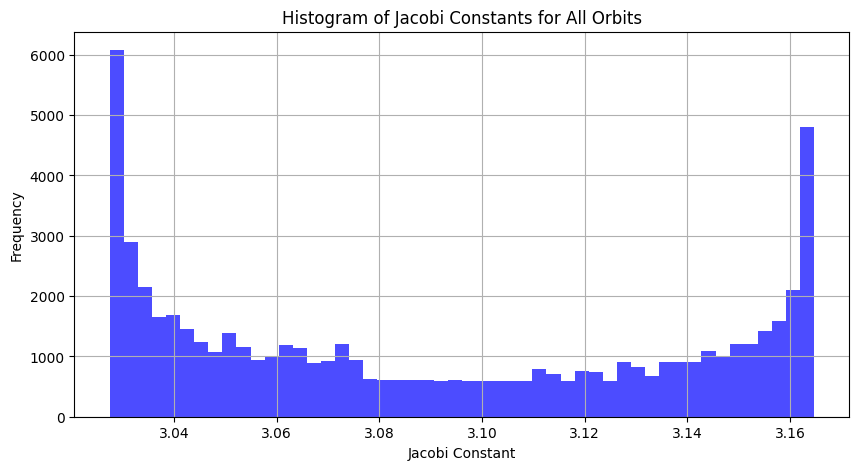

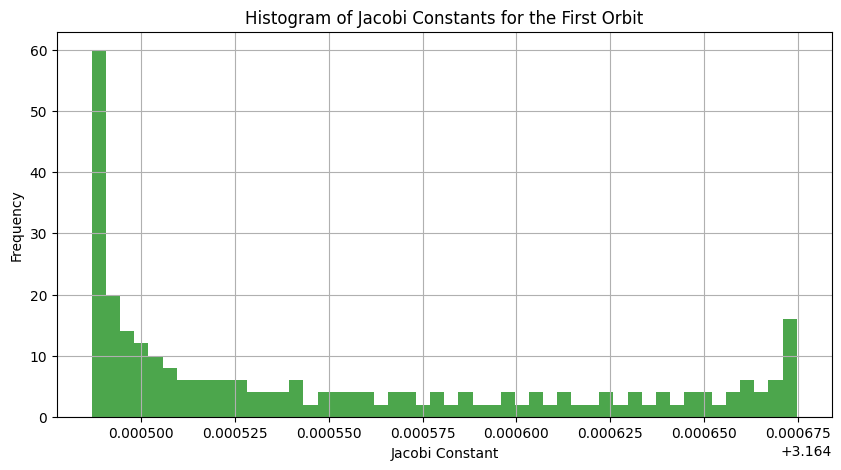

In [18]:
# | test jacobi_constant
# Calculate Jacobi constants and energies for all orbits at all time points
jacobi_constants = np.zeros((200, 300))
total_energies = np.zeros((200, 300))

for orbit_index in range(200):
    for time_index in range(300):
        X = orbit_data[orbit_index, :, time_index]
        J, E = jacobi_constant(X, MU)
        jacobi_constants[orbit_index, time_index] = J
        total_energies[orbit_index, time_index] = E

# Flatten the Jacobi constants array to plot the histogram of all values
jacobi_constants_all = jacobi_constants.flatten()

# Plot histogram of Jacobi constants for all orbits
plt.figure(figsize=(10, 5))
plt.hist(jacobi_constants_all, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Jacobi Constants for All Orbits')
plt.xlabel('Jacobi Constant')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram of Jacobi constants for the first orbit
jacobi_constants_first_orbit = jacobi_constants[0, :]

plt.figure(figsize=(10, 5))
plt.hist(jacobi_constants_first_orbit, bins=50, color='green', alpha=0.7)
plt.title('Histogram of Jacobi Constants for the First Orbit')
plt.xlabel('Jacobi Constant')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Equations of motion CR3BP

In [5]:
# | export
def eom_cr3bp(t: float,  # Time variable (not used in this formulation)
              X: np.ndarray,  # State vector with 6 components (x, y, z, v_x, v_y, v_z)
              mu: float  # Gravitational parameter
             ) -> List[float]:
    """
    Equations of motion for the Circular Restricted 3 Body Problem (CR3BP). 
    The form is X_dot = f(t, X, (parameters,)). This formulation is time-independent 
    as it does not depend explicitly on t.
    
    Parameters:
    t (float): Time variable (not used in this formulation).
    X (np.ndarray): State vector with 6 components (x, y, z, v_x, v_y, v_z).
    mu (float): Gravitational parameter.

    Returns:
    List[float]: Derivatives of the state vector.
    """
    
    # Unpack state vector components
    x, y, z, v_x, v_y, v_z = X

    # Position of spacecraft with respect to primary bodies
    r1 = np.sqrt((x + mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x - (1 - mu))**2 + y**2 + z**2)
    
    # State ODE:
    x_dot  = v_x
    y_dot  = v_y
    z_dot  = v_z
    x_ddot = x + 2 * v_y - (1 - mu) * (x + mu) / r1**3 - mu * (x - (1 - mu)) / r2**3
    y_ddot = y - 2 * v_x - y * ((1 - mu) / r1**3 + mu / r2**3)
    z_ddot = -z * ((1 - mu) / r1**3 + mu / r2**3)

    # Return the state derivatives as a list
    Xdot = [x_dot, y_dot, z_dot, x_ddot, y_ddot, z_ddot]
   
    return Xdot

## Propagation

In [6]:
# | export
def prop_node(X: np.ndarray,  # Initial state vector with 6 components (x, y, z, v_x, v_y, v_z)
              dt: float,  # Time step for propagation
              mu: float  # Gravitational parameter
             ) -> np.ndarray:
    """
    Return the state X after a given time step dt = T_end - T_start.
    
    Parameters:
    X (np.ndarray): Initial state vector with 6 components (x, y, z, v_x, v_y, v_z).
    dt (float): Time step for propagation.
    mu (float): Gravitational parameter.
    
    Returns:
    np.ndarray: Final state vector after time step dt.
    """
    # Solve the initial value problem using the eom_cr3bp function
    sol = solve_ivp(
        eom_cr3bp, [0, dt], X, args=(mu,), dense_output=True,
        rtol=relative_tolerance, atol=absolute_tolerance, method='Radau'
    )
    
    # Return the final state vector
    return sol.y.T[-1]

## Compute Error

In [7]:
# | export
def jacobi_test(X: np.ndarray,  # State vector with shape (n, 6) or (n, 7), where n is the number of samples
                mu: float  # Gravitational parameter
               ) -> float:
    """
    Compute the energy error. X can have either 6 columns (state vector) or 7 columns (time + state vector).
    The returned quantity is the cumulative error with respect to the initial value. If propagation is perfect, err = 0 (or very small).
    
    Parameters:
    X (np.ndarray): State vector with shape (n, 6) or (n, 7), where n is the number of samples.
    mu (float): Gravitational parameter.
    
    Returns:
    float: Cumulative energy error with respect to the initial value.
    """
    n, k = np.shape(X)
    
    # Initial Jacobi constant
    J0 = jacobi_constant(X[0, (k-6):k], mu)[0]
    
    err = 0.0
    # Compute cumulative error
    for i in range(n):
        Ji = jacobi_constant(X[i, (k-6):k], mu)[0]
        err += np.abs(J0 - Ji)
    
    return err

In [8]:
# | export
def dynamics_defect(X: np.ndarray,  # Time-state vector with shape (n, 7), where the first column is the time vector
                    mu: float  # Gravitational parameter
                   ) -> Tuple[float, float]:
    """
    Compute the dynamical defect for the generated time-state sequence. 
    The returned quantity is the cumulative error on the position and velocity components.
    The overall metrics can be a combination of these two last errors.
    
    Parameters:
    X (np.ndarray): Time-state vector with shape (n, 7), where the first column is the time vector.
    mu (float): Gravitational parameter.
    
    Returns:
    Tuple[float, float]: Cumulative errors in position and velocity.
    """
    n, m = np.shape(X)
    if m != 7:
        raise TypeError("X must be of size (n, 7). The first column is the time vector.")
    
    errX = 0.0  # Error in the position vector
    errV = 0.0  # Error in the velocity vector

    for i in range(n - 1):
        X_start = X[i, 1:7]
        X_end = X[i + 1, 1:7]
        dt = X[i + 1, 0] - X[i, 0]
        X_test = prop_node(X_start, dt, mu)
        err = X_test - X_end

        errX += np.linalg.norm(err[0:3])
        errV += np.linalg.norm(err[3:6])
    
    return errX, errV

In [ ]:
# Example of propagation and plotting
X0 = [8.2339081983651485E-1, -1.9017764504099543E-28, 9.8941366235910004E-4, -2.3545391932685812E-15, 1.2634272983881797E-1, 2.2367029429442455E-16]
mu = 1.215058560962404E-2
T0 = 2.7430007981241529E+0

sol = solve_ivp(eom_cr3bp, [0, T0], X0, args=(mu,), dense_output=True, rtol=relative_tolerance, atol=absolute_tolerance, method='Radau')
tvec = np.linspace(0, T0, 100)
z = sol.sol(tvec)

# Visualize the numerically propagated orbit
data = z.reshape((1, 6, len(tvec)))  # Reshape to fit the expected input format for visualize_static_orbits
visualize_static_orbits(data, time_instants=[0, 50, 99], orbit_indices=[0])

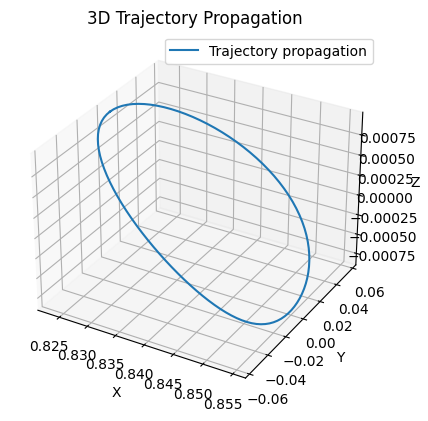

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/walth/OneDrive - University of Strathclyde/PROJECTS/OrbitGPT/files/OUTPUTS/generation_240515.npy'

In [9]:
# Define the initial conditions and parameters
X0 = [8.2339081983651485E-1, -1.9017764504099543E-28, 9.8941366235910004E-4, -2.3545391932685812E-15, 1.2634272983881797E-1, 2.2367029429442455E-16]
mu = 1.215058560962404E-2
T0 = 2.7430007981241529E+0

# Propagate the orbit using the solve_ivp function with Radau method
sol = solve_ivp(eom_cr3bp, [0, T0], X0, args=(mu,), dense_output=True, rtol=relative_tolerance, atol=absolute_tolerance, method='Radau')

# Create a time vector for evaluation of the solution
tvec = np.linspace(0, T0, 100)

# Evaluate the solution at the specified time points
z = sol.sol(tvec)

# Plot the trajectory in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(z[0], z[1], z[2], label='Trajectory propagation')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('3D Trajectory Propagation')
plt.show()

# Load the generated trajectory file
file_path = "C:/Users/walth/OneDrive - University of Strathclyde/PROJECTS/OrbitGPT/files/OUTPUTS/generation_240515.npy"
myarray = np.load(file_path)
mat = myarray[0, :, :]  # Load the first generated trajectory

# Build the 7-column matrix for the propagated state
mat_propagated = np.hstack((tvec.reshape(-1, 1), z.T))

# Calculate and print the dynamic defect error for the numerically propagated orbit
print("Dynamic defect on numerically propagated orbit: ", dynamics_defect(mat_propagated, mu))

# Calculate and print the dynamic defect error for the generated orbit
print("Dynamic defect on generated orbit: ", dynamics_defect(mat, mu))

# Calculate and print the energy error for the numerically propagated orbit
print("Energy error on numerically propagated orbit: ", jacobi_test(mat_propagated, mu))

# Calculate and print the energy error for the generated orbit
print("Energy error on generated orbit: ", jacobi_test(mat, mu))
